<a href="https://colab.research.google.com/github/amirkasaei/Intelligent-Analysis-of-Biomedical-Images/blob/main/HW/SPB_HW2/Prac/BrainMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import**

In [1]:
!pip install wandb -q

In [2]:
import wandb
import os
import numpy as np
import seaborn as sns
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io
import torch
import random
import pandas as pd
import glob
from sklearn.preprocessing import StandardScaler, normalize
import sklearn
from sklearn import metrics
from IPython.display import display
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import copy
import pickle
import torch.optim as optim
from torch.optim import lr_scheduler

# **Config**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
RANDOM_SEED = 42 # Must be used wherever can be used

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
wandb.login(key='7f5c6eb77da002a218a74f8af39a66beeb83e891')
# 7f5c6eb77da002a218a74f8af39a66beeb83e891

wandb: Currently logged in as: amirkasaei. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# **Preprocessing**

## **Load Data**

In [7]:
path = '/content/drive/MyDrive/AI/Deep Learning/SPB/HW2/'

In [8]:
classes = ['Ⅿeningioⅿa', 'Gⅼioⅿa', 'Pitutary']

In [9]:
phases = ['train', 'validation', 'test']
data = {}
for phase in phases:
  pickle_in = open(path+phase+".pickle","rb")
  data[phase] = np.array(pickle.load(pickle_in))
  data[phase][:, 1] -= 1

<ipython-input-9-1a0baecb341f>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data[phase] = np.array(pickle.load(pickle_in))


## **Visualize data**

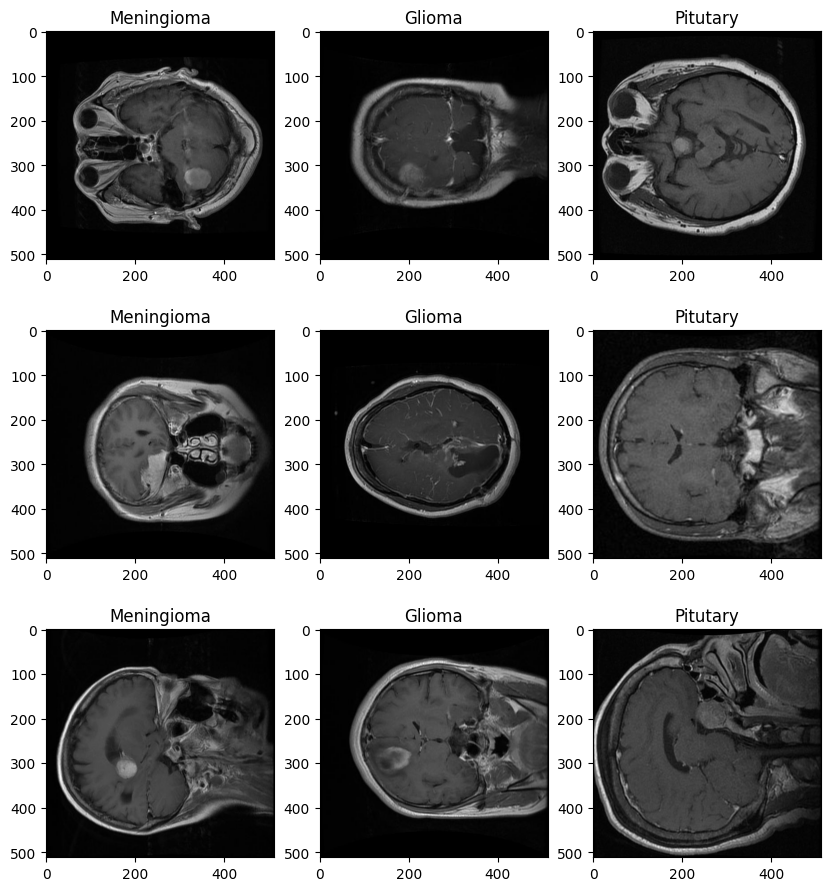

In [10]:
fig,axs = plt.subplots(3,3, figsize=(10,11))
for i in range(3):
    for j in range(3):
      idx = np.where(data['train'][:, 1] == j)[0]
      k = np.random.choice(idx)
      axs[i][j].title.set_text(classes[j])
      axs[i][j].imshow(data['train'][k][0])

## **Dataset & DataLoader**

In [11]:
class BrainMRIDataset(Dataset):
    def __init__(self, data, image_transform=None):
        self.data = data
        self.image_transform = image_transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
      if self.image_transform:
        image = self.image_transform(self.data[idx][0])
      else:
        image = self.data[idx][0]

      label = float(self.data[idx][1])

      return image, label


In [12]:
BATCH_SIZE = 64
size = 256

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(256, interpolation=torchvision.transforms.InterpolationMode.BILINEAR,antialias=True),
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(256, interpolation=torchvision.transforms.InterpolationMode.BILINEAR,antialias=True),
])


train_dataset = BrainMRIDataset(
    data['train'],
    image_transform=train_transform,
)
val_dataest = BrainMRIDataset(
    data['validation'],
    image_transform=test_transform,
)
test_dataset = BrainMRIDataset(
    data['test'],
    image_transform=test_transform,
)

dataloaders = {}

dataloaders['train'] = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataloaders['validation'] = DataLoader(val_dataest, batch_size=BATCH_SIZE, shuffle=False)
dataloaders['test'] = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# **Classification**

## **Helper Function**

In [44]:
def plot_confusionmatrix(y_train_pred,y_train, classes):
  print('Confusion matrix')
  cf = sklearn.metrics.confusion_matrix(y_train_pred,y_train)
  sns.heatmap(cf,annot=True,yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='g')
  plt.tight_layout()
  plt.show()

In [45]:
def report(model, loader, device, classes):

  # Each epoch has a training and validation phase
  model.eval()   # Set model to evaluate mode

  y_pred = []
  y_true = []

  # Iterate over data.
  for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.type(torch.LongTensor)

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      y_pred.extend(preds.cpu())
      y_true.extend(labels)

  plot_confusionmatrix(y_pred, y_true, classes)

In [46]:
def one_epoch(model, loader, criterion, optimizer, scheduler, device, phase):

  model.train()  # Set model to training mode

  running_loss = 0.0
  running_accuracy = 0.0
  running_precision = 0.0
  running_recall = 0.0
  running_f1_score = 0.0

  # Iterate over data.
  for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.type(torch.LongTensor).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    with torch.set_grad_enabled(phase == 'train'):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

      if phase == 'train':
        loss.backward()
        optimizer.step()

    # statistics
    running_loss += loss.item()
    running_accuracy += sklearn.metrics.accuracy_score(labels.cpu(), preds.cpu())
    running_precision += sklearn.metrics.precision_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    running_recall += sklearn.metrics.recall_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    running_f1_score += sklearn.metrics.f1_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)

    # if phase == 'train' and not scheduler:
    #     scheduler.step()

  loss = running_loss / len(loader)
  accuracy = running_accuracy / len(loader)
  precision = running_precision / len(loader)
  recall = running_recall / len(loader)
  f1_score = running_f1_score / len(loader)

  return loss, accuracy, precision, recall, f1_score

In [47]:
def train(model, loaders, criterion, optimizer, num_epochs, device, scheduler=None):

  accuracy_dic, loss_dic = {}, {}
  loss_dic['train'], loss_dic['validation'] = [], []
  accuracy_dic['train'], accuracy_dic['validation'] = [], []

  for epoch in range(num_epochs):
      train_loss, train_acc, train_precision, train_recall, train_f1 = one_epoch(model, loaders['train'], criterion, optimizer, scheduler, device, phase='train' )
      val_loss, val_acc, val_precision, val_recall, val_f1 = one_epoch(model, loaders['validation'], criterion, optimizer, scheduler, device, phase='validation')

      loss_dic['train'].append(train_loss)
      loss_dic['validation'].append(val_loss)
      accuracy_dic['train'].append(train_acc)
      accuracy_dic['validation'].append(val_acc)

      wandb.log({"Train Loss": train_loss, "Train Accuracy":train_acc, "Validation Loss": val_loss, "Validation Accuracy":val_acc})

      print(f'Epoch [{epoch+1}/{num_epochs}] - '
            f'Train Loss: {train_loss:.4f} - '
            f'Train Accuracy: {train_acc:.4f} - '
            f'Validation Loss: {val_loss:.4f} - '
            f'Validation Accuracy {val_acc:.4f}% - '
            f'Validation Precision {val_precision:.4f}% - '
            f'Validation Recall {val_recall:.4f}% - '
            f'Validation F1-score {val_f1:.4f}% ')

  return loss_dic, accuracy_dic

In [48]:
def evaluate(model, loaders, criterion, optimizer, device, phase, scheduler=None):

  loss, accuracy, precision, recall, f1_score = one_epoch(model, loaders[phase], criterion, optimizer, scheduler, device, phase)

  print(f'{phase} Loss: {loss:.4f} - '
        f'{phase} Acuracy {accuracy:.4f}% - '
        f'{phase} Precision: {precision:.4f}% - '
        f'{phase} Recall {recall:.4f}% - '
        f'{phase} F1: {f1_score:.2f}%')


In [49]:
def show_plots(num_epochs, data, metric):
  e = np.arange(num_epochs)
  plt.plot(e, data['train'], label='train '+metric)
  plt.plot(e, data['validation'], label='validation '+metric)
  plt.xlabel('epoch')
  plt.ylabel(metric)
  plt.legend()

## **From Scratch**

### **Implementation**

In [ ]:
class AlexNet(nn.Module):
    def __init__(self ):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 3),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### **Train**

In [ ]:
model_sc = AlexNet()
model_sc.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
scratch = wandb.init(project='BrainMRI', name='scratch')

wandb: Currently logged in as: amirkasaei. Use `wandb login --relogin` to force relogin


In [ ]:
lr = 1e-4
num_epochs = 30

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_sc.parameters()), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_dic, accuracy_dic = train(model_sc, dataloaders, criterion, optimizer, num_epochs, device)

scratch.finish()

Epoch [1/30] - Train Loss: 1.0335 - Train Accuracy: 0.4868 - Validation Loss: 0.9551 - Validation Accuracy 0.4639% - Validation Precision 0.2276% - Validation Recall 0.4639% - Validation F1-score 0.3019% 
Epoch [2/30] - Train Loss: 0.7690 - Train Accuracy: 0.6586 - Validation Loss: 0.7026 - Validation Accuracy 0.6615% - Validation Precision 0.5092% - Validation Recall 0.6615% - Validation F1-score 0.5709% 
Epoch [3/30] - Train Loss: 0.6754 - Train Accuracy: 0.6821 - Validation Loss: 0.7837 - Validation Accuracy 0.6490% - Validation Precision 0.4958% - Validation Recall 0.6490% - Validation F1-score 0.5578% 
Epoch [4/30] - Train Loss: 0.6217 - Train Accuracy: 0.7068 - Validation Loss: 0.6347 - Validation Accuracy 0.7110% - Validation Precision 0.7265% - Validation Recall 0.7110% - Validation F1-score 0.7058% 
Epoch [5/30] - Train Loss: 0.6044 - Train Accuracy: 0.7095 - Validation Loss: 0.5569 - Validation Accuracy 0.7141% - Validation Precision 0.7172% - Validation Recall 0.7141% - Vali

Train Accuracy,▁▃▄▄▄▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇████████
Train Loss,█▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Validation Accuracy,▁▄▄▅▅▅▅▆▆▆▆▇▆▇▇▆▇█▇█▇█████████
Validation Loss,█▆▆▅▄▄▄▄▃▃▃▂▃▃▂▃▂▁▂▂▂▁▂▁▁▁▁▁▁▂
Train Accuracy,0.97837
Train Loss,0.06401
Validation Accuracy,0.909
Validation Loss,0.23693


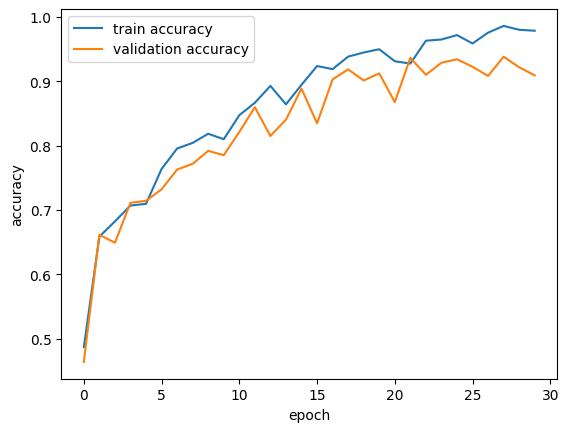

In [ ]:
show_plots(num_epochs, accuracy_dic, 'accuracy')

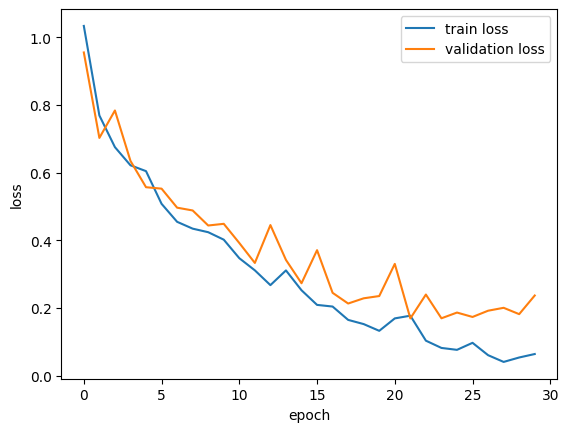

In [ ]:
show_plots(num_epochs, loss_dic, 'loss')

**W&B**

Loss
<div align="center"><img src="https://raw.githubusercontent.com/amirkasaei/Intelligent-Analysis-of-Biomedical-Images/main/HW/SPB_HW2/Prac/W%26B%20Chart%20Acc%20scratch.png" width="70%" /></div>

Accurcay
<div align="center"><img src="https://raw.githubusercontent.com/amirkasaei/Intelligent-Analysis-of-Biomedical-Images/main/HW/SPB_HW2/Prac/W%26B%20Chart%20Loss%20scratch.png" width="70%" /></div>

### **Evaluation**

#### **Train**

In [ ]:
evaluate(model_sc, dataloaders, criterion, optimizer, device, 'train')

train Loss: 0.0217 - train Acuracy 0.9932% - train Precision: 0.9935% - train Recall 0.9932% - train F1: 0.99%


Confusion matrix


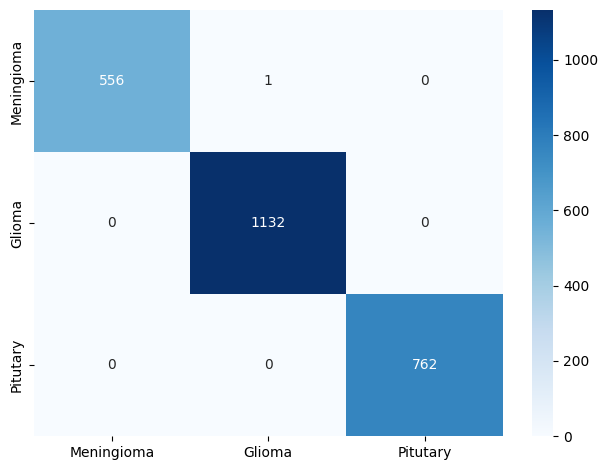

In [ ]:
report(model_sc, dataloaders['train'], device, classes)

#### **Validation**

In [ ]:
evaluate(model_sc, dataloaders, criterion, optimizer, device, 'validation')

validation Loss: 0.1337 - validation Acuracy 0.9567% - validation Precision: 0.9621% - validation Recall 0.9567% - validation F1: 0.96%


Confusion matrix


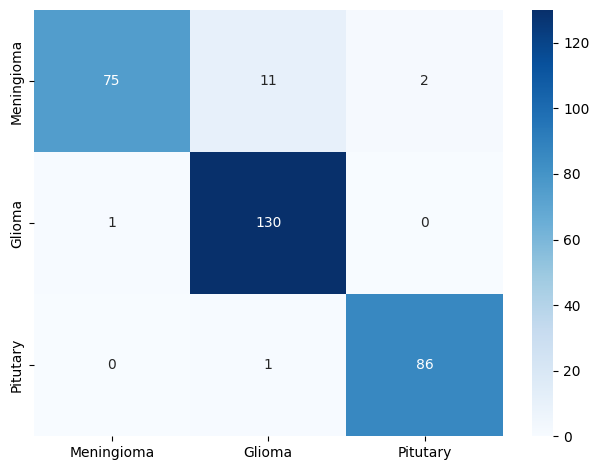

In [ ]:
report(model_sc, dataloaders['validation'], device, classes)

#### **Test**

In [ ]:
evaluate(model_sc, dataloaders, criterion, optimizer, device, 'test')

test Loss: 0.1601 - test Acuracy 0.9523% - test Precision: 0.9548% - test Recall 0.9523% - test F1: 0.95%


Confusion matrix


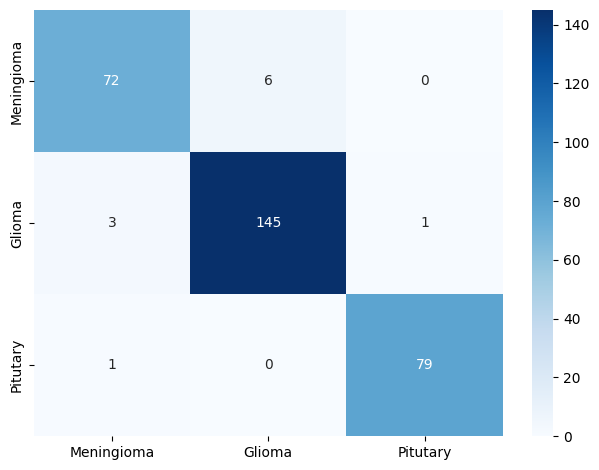

In [ ]:
report(model_sc, dataloaders['test'], device, classes)

## **Pretrained**

### **Implementation**

In [ ]:
model_pt = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 145MB/s]


In [ ]:
input_features = model_pt.classifier[-1].in_features
model_pt.classifier[-1] = nn.Linear(in_features=input_features, out_features=3, bias=True)
# model_pt.classifier =nn.Sequential(
#             nn.Dropout(p=0.5),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, 3),)
model_pt.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
for param in model_pt.features.parameters():
    param.require_grad = False

### **Train**

In [ ]:
pretrained = wandb.init(project='BrainMRI', name='pretrained')

In [ ]:
lr = 1e-4
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_pt.parameters()), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_dic, accuracy_dic = train(model_pt, dataloaders, criterion, optimizer, num_epochs, device)

pretrained.finish()

Epoch [1/10] - Train Loss: 0.5367 - Train Accuracy: 0.7732 - Validation Loss: 0.3164 - Validation Accuracy 0.8689% - Validation Precision 0.8755% - Validation Recall 0.8689% - Validation F1-score 0.8700% 
Epoch [2/10] - Train Loss: 0.2616 - Train Accuracy: 0.8995 - Validation Loss: 0.2406 - Validation Accuracy 0.8988% - Validation Precision 0.9067% - Validation Recall 0.8988% - Validation F1-score 0.8997% 
Epoch [3/10] - Train Loss: 0.1607 - Train Accuracy: 0.9273 - Validation Loss: 0.2142 - Validation Accuracy 0.9121% - Validation Precision 0.9251% - Validation Recall 0.9121% - Validation F1-score 0.9156% 
Epoch [4/10] - Train Loss: 0.1679 - Train Accuracy: 0.9359 - Validation Loss: 0.1928 - Validation Accuracy 0.9335% - Validation Precision 0.9382% - Validation Recall 0.9335% - Validation F1-score 0.9344% 
Epoch [5/10] - Train Loss: 0.0952 - Train Accuracy: 0.9631 - Validation Loss: 0.1755 - Validation Accuracy 0.9255% - Validation Precision 0.9271% - Validation Recall 0.9255% - Vali

Train Accuracy,▁▅▆▆▇▇████
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▅▇▆▅▆▇█▄
Validation Loss,█▄▃▂▁▄▄▂▂█
Train Accuracy,0.98343
Train Loss,0.03917
Validation Accuracy,0.90412
Validation Loss,0.31865


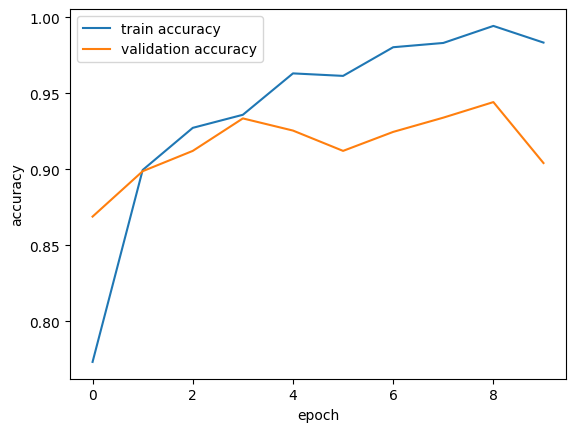

In [ ]:
show_plots(num_epochs, accuracy_dic, 'accuracy')

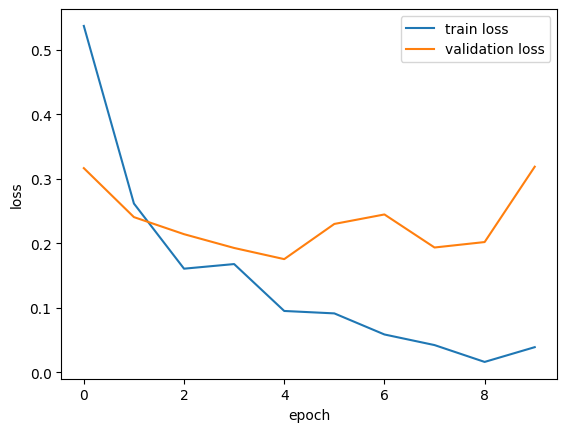

In [ ]:
show_plots(num_epochs, loss_dic, 'loss')

**W&B**

Loss
<div align="center"><img src="https://raw.githubusercontent.com/amirkasaei/Intelligent-Analysis-of-Biomedical-Images/main/HW/SPB_HW2/Prac/W%26B%20Chart%20Acc%20pretrained.png" width="70%" /></div>

Accurcay
<div align="center"><img src="https://raw.githubusercontent.com/amirkasaei/Intelligent-Analysis-of-Biomedical-Images/main/HW/SPB_HW2/Prac/W%26B%20Chart%20Loss%20pretrained.png"" width="70%" /></div>

### **Evaluation**

#### **Train**

In [ ]:
evaluate(model_pt, dataloaders, criterion, optimizer, device, 'train')

train Loss: 0.0210 - train Acuracy 0.9928% - train Precision: 0.9935% - train Recall 0.9928% - train F1: 0.99%


Confusion matrix


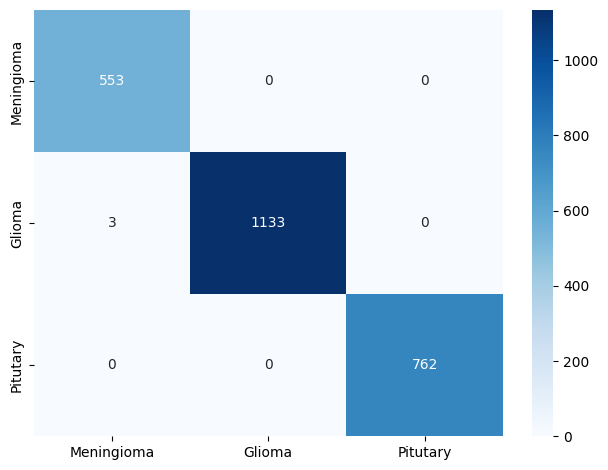

In [ ]:
report(model_pt, dataloaders['train'], device, classes)

#### **Validation**

In [ ]:
evaluate(model_pt, dataloaders, criterion, optimizer, device, 'validation')

validation Loss: 0.1312 - validation Acuracy 0.9474% - validation Precision: 0.9487% - validation Recall 0.9474% - validation F1: 0.95%


Confusion matrix


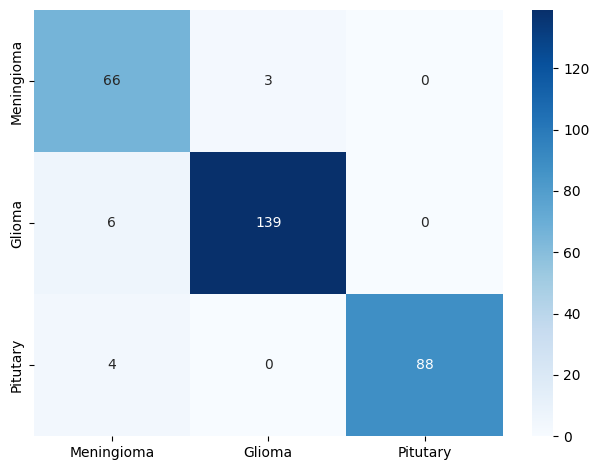

In [ ]:
report(model_pt, dataloaders['validation'], device, classes)

#### **Test**

In [ ]:
evaluate(model_pt, dataloaders, criterion, optimizer, device, 'test')

test Loss: 0.1266 - test Acuracy 0.9515% - test Precision: 0.9527% - test Recall 0.9515% - test F1: 0.95%


Confusion matrix


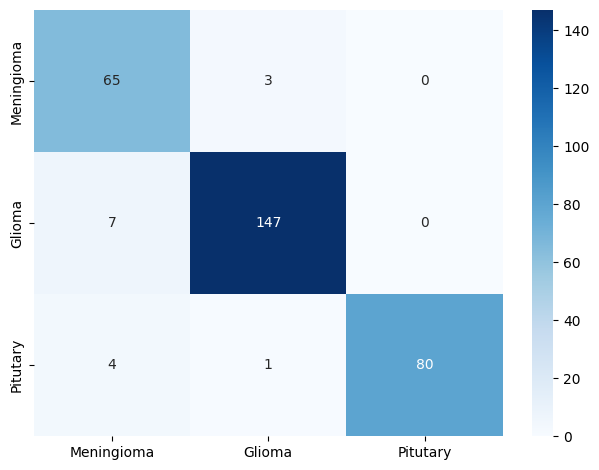

In [ ]:
report(model_pt, dataloaders['test'], device, classes)

# **Spervised Contrastive Learning**

### **Helper Function**

In [13]:
def one_supcon_epoch(model, loader, criterion, optimizer, scheduler, device, phase):

  model.train()  # Set model to training mode

  running_loss = 0.0

  # Iterate over data.
  for inputs, labels in loader:
    # concatenate two augmented images
    inputs = torch.cat(inputs, dim=0).to(device)
    labels = labels.type(torch.LongTensor).to(device)


    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    with torch.set_grad_enabled(phase == 'train'):
      bsz = labels.shape[0]
      # compute loss
      features = model(inputs)
      f1, f2 = torch.split(features, [bsz, bsz], dim=0)
      features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

      loss = criterion(features, labels)

      if phase == 'train':
        loss.backward()
        optimizer.step()

    # statistics
    running_loss += loss.item()

    # if phase == 'train' and not scheduler:
    #     scheduler.step()

  loss = running_loss / len(loader)

  return loss

In [14]:
def supcon_train(model, loaders, criterion, optimizer, num_epochs, device, scheduler=None):

  loss_dic = {}
  loss_dic['train'], loss_dic['validation'] = [], []

  for epoch in range(num_epochs):
      train_loss = one_supcon_epoch(model, loaders['train'], criterion, optimizer, scheduler, device, phase='train' )
      val_loss= one_supcon_epoch(model, loaders['validation'], criterion, optimizer, scheduler, device, phase='validation')

      loss_dic['train'].append(train_loss)
      loss_dic['validation'].append(val_loss)

      wandb.log({"Train Loss": train_loss, "Validation Loss": val_loss})

      print(f'Epoch [{epoch+1}/{num_epochs}] - '
            f'Train Loss: {train_loss:.4f} - '
            f'Validation Loss: {val_loss:.4f}')

  return loss_dic

### **Implementation**

In [15]:
BATCH_SIZE = 64
size = 256

In [16]:
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

In [32]:
supcon_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Resize(size, interpolation=torchvision.transforms.InterpolationMode.BILINEAR,antialias=True),
        # torchvision.transforms.RandomResizedCrop(size=size, scale=(0.2, 1.), antialias=True),
        torchvision.transforms.RandomHorizontalFlip(),
    ])

In [33]:
supcon_train_dataset = BrainMRIDataset(
    data['train'],
    image_transform=TwoCropTransform(supcon_transform),
)
supcon_val_dataest = BrainMRIDataset(
    data['validation'],
    image_transform=TwoCropTransform(supcon_transform),
)
supcon_test_dataset = BrainMRIDataset(
    data['test'],
    image_transform=TwoCropTransform(supcon_transform),
)

supcon_dataloaders = {}

supcon_dataloaders['train'] = DataLoader(supcon_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
supcon_dataloaders['validation'] = DataLoader(supcon_val_dataest, batch_size=BATCH_SIZE, shuffle=False)
supcon_dataloaders['test'] = DataLoader(supcon_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### **SupCon Loss**

In [19]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

#### **Model**

In [20]:
class SupConAlexNetEncoder(nn.Module):
    def __init__(self ):
        super(SupConAlexNetEncoder, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.projector = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 64),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.projector(x)
        return x

In [40]:
class SupConAlexNetClassifier(nn.Module):
    def __init__(self, encoder):
        super(SupConAlexNetClassifier, self).__init__()
        self.encoder = encoder
        output_features = self.encoder.projector[-1].out_features
        self.classifier = nn.Linear(in_features=output_features, out_features=3, bias=True)

        # for param in self.encoder.features.parameters():
        #   param.require_grad = False

        # for param in self.encoder.features.projector():
        #   param.require_grad = False


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.classifier(x)
        return x

### **Train**

#### encoder

In [36]:
supcon_encoder = SupConAlexNetEncoder()
supcon_encoder.to(device)

SupConAlexNetEncoder(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (projector): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, 

In [37]:
supcon_en_logger = wandb.init(project='BrainMRI', name='SupCon Encoder')

In [38]:
lr = 1e-4
num_epochs = 10

supcon_criterion = SupConLoss(temperature=0.07, base_temperature=0.07)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, supcon_encoder.parameters()), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_dic = supcon_train(supcon_encoder, supcon_dataloaders, supcon_criterion, optimizer, num_epochs, device)

supcon_en_logger.finish()

Epoch [1/10] - Train Loss: 4.7430 - Validation Loss: 4.6606
Epoch [2/10] - Train Loss: 4.6201 - Validation Loss: 4.6298
Epoch [3/10] - Train Loss: 4.5634 - Validation Loss: 4.5303
Epoch [4/10] - Train Loss: 4.4963 - Validation Loss: 4.4944
Epoch [5/10] - Train Loss: 4.4682 - Validation Loss: 4.4903
Epoch [6/10] - Train Loss: 4.4337 - Validation Loss: 4.4829
Epoch [7/10] - Train Loss: 4.4205 - Validation Loss: 4.4450
Epoch [8/10] - Train Loss: 4.4026 - Validation Loss: 4.4609
Epoch [9/10] - Train Loss: 4.3714 - Validation Loss: 4.4155
Epoch [10/10] - Train Loss: 4.3521 - Validation Loss: 4.4062


Train Loss,█▆▅▄▃▂▂▂▁▁
Validation Loss,█▇▄▃▃▃▂▃▁▁
Train Loss,4.35212
Validation Loss,4.40616


**W&B**

Loss
<div align="center"><img src="https://raw.githubusercontent.com/amirkasaei/Intelligent-Analysis-of-Biomedical-Images/main/HW/SPB_HW2/Prac/W%26B%20Chart%20Loss%20SupCon%20encoder.png"" width="70%" /></div>

#### classifier

In [41]:
supcon_classifier = SupConAlexNetClassifier(supcon_encoder)
supcon_classifier.to(device)

SupConAlexNetClassifier(
  (encoder): SupConAlexNetEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (projector): Sequential(
      (0): Dropout(p

In [42]:
supcon_class_logger = wandb.init(project='BrainMRI', name='SupCon Classifier')

In [50]:
lr = 1e-4
num_epochs = 5

entropy_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, supcon_classifier.parameters()), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_dic, accuracy_dic = train(supcon_classifier, dataloaders, entropy_criterion, optimizer, num_epochs, device)

supcon_class_logger.finish()

Epoch [1/5] - Train Loss: 0.7009 - Train Accuracy: 0.6990 - Validation Loss: 0.6963 - Validation Accuracy 0.6883% - Validation Precision 0.7595% - Validation Recall 0.6883% - Validation F1-score 0.6864% 
Epoch [2/5] - Train Loss: 0.5567 - Train Accuracy: 0.7403 - Validation Loss: 0.5693 - Validation Accuracy 0.7070% - Validation Precision 0.5931% - Validation Recall 0.7070% - Validation F1-score 0.6166% 
Epoch [3/5] - Train Loss: 0.4972 - Train Accuracy: 0.7767 - Validation Loss: 0.5634 - Validation Accuracy 0.7369% - Validation Precision 0.7191% - Validation Recall 0.7369% - Validation F1-score 0.6734% 
Epoch [4/5] - Train Loss: 0.4625 - Train Accuracy: 0.7884 - Validation Loss: 0.4273 - Validation Accuracy 0.8140% - Validation Precision 0.8327% - Validation Recall 0.8140% - Validation F1-score 0.8177% 
Epoch [5/5] - Train Loss: 0.4099 - Train Accuracy: 0.8178 - Validation Loss: 0.4105 - Validation Accuracy 0.8131% - Validation Precision 0.8278% - Validation Recall 0.8131% - Validatio

Train Accuracy,▁▃▆▆█
Train Loss,█▅▃▂▁
Validation Accuracy,▁▂▄██
Validation Loss,█▅▅▁▁
Train Accuracy,0.81781
Train Loss,0.40994
Validation Accuracy,0.81312
Validation Loss,0.41048


**W&B**

Loss
<div align="center"><img src="https://raw.githubusercontent.com/amirkasaei/Intelligent-Analysis-of-Biomedical-Images/main/HW/SPB_HW2/Prac/W%26B%20Chart%20Acc%20SupCon%20classifier.png" width="70%" /></div>

Accurcay
<div align="center"><img src="https://raw.githubusercontent.com/amirkasaei/Intelligent-Analysis-of-Biomedical-Images/main/HW/SPB_HW2/Prac/W%26B%20Chart%20Loss%20SupCon%20classifier.png"" width="70%" /></div>

### **Evaluation**

#### **Train**

In [58]:
evaluate(supcon_classifier, dataloaders, entropy_criterion, optimizer, device, 'train')

train Loss: 0.3600 - train Acuracy 0.8448% - train Precision: 0.8529% - train Recall 0.8448% - train F1: 0.84%


Confusion matrix


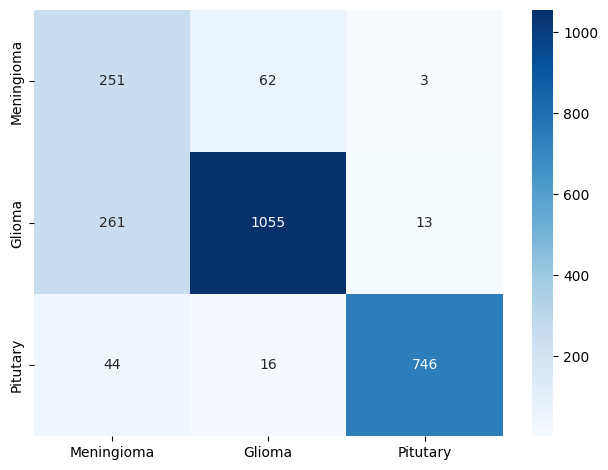

In [52]:
report(supcon_classifier, dataloaders['train'], device, classes)

#### **Validation**

In [56]:
evaluate(supcon_classifier, dataloaders, entropy_criterion, optimizer, device, 'validation')

validation Loss: 0.4260 - validation Acuracy 0.8020% - validation Precision: 0.8103% - validation Recall 0.8020% - validation F1: 0.79%


Confusion matrix


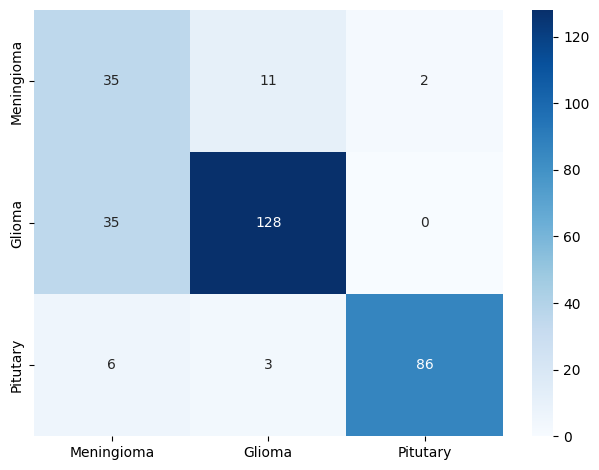

In [54]:
report(supcon_classifier, dataloaders['validation'], device, classes)

#### **Test**

In [57]:
evaluate(supcon_classifier, dataloaders, entropy_criterion, optimizer, device, 'test')

test Loss: 0.4184 - test Acuracy 0.8241% - test Precision: 0.8327% - test Recall 0.8241% - test F1: 0.81%


Confusion matrix


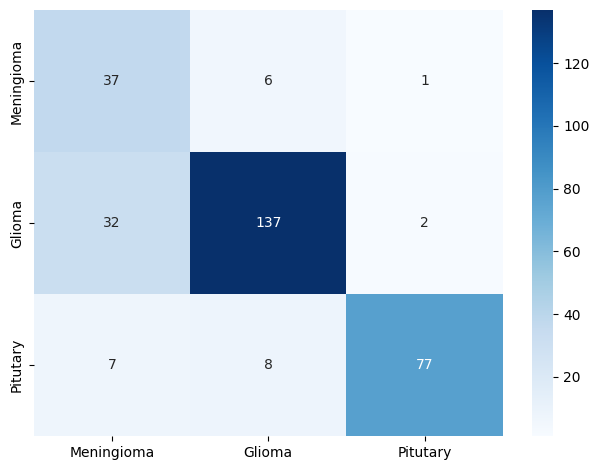

In [55]:
report(supcon_classifier, dataloaders['test'], device, classes)

# **Refrences**

- [Torchvision](https://pytorch.org/vision/stable/models.html)

- [wandb](https://docs.wandb.ai/guides/app/features/panels/line-plot)

- [SupContrast GitHub](https://github.com/HobbitLong/SupContrast)